Deskripsi atau Langkah-langkah yang akan saya lakukan dalam proyek ini:

1. Persiapan Data:

- Membuka dan mempelajari data yang tersedia.
- Memeriksa kebenaran perhitungan perolehan emas dengan menghitung MAE antara perhitungan dan nilai fitur yang ada.
- Analisis terhadap fitur-fitur yang tidak tersedia pada set pengujian.
- Melakukan pra-pemrosesan data.

2. Analisis Data:

- Membuat catatan tentang bagaimana konsentrasi logam berubah selama tahap pemurnian.
- Membandingkan distribusi ukuran partikel feed antara training set dan test set.
- Meninjau total konsentrasi semua substansi di tahap yang berbeda dan mempertimbangkan nilai abnormal.

3. Pembuatan Model:

- Membuat fungsi untuk menghitung nilai sMAPE.
- Melakukan pelatihan pada berbagai model dan mengevaluasinya menggunakan cross-validation.
- Memilih model terbaik dan mengujinya menggunakan sampel tes.

4. Evaluasi Proyek:

- Memastikan persiapan data dan analisis data dilakukan dengan benar.
- Menyajikan model yang dibuat dan mengevaluasi kualitasnya.
- Memastikan setiap langkah yang diinstruksikan diikuti dengan baik.
- Menjaga kerapian kode dan mencegah duplikasi kode.

Dengan langkah-langkah ini, saya akan dapat mempersiapkan, menganalisis, dan mengembangkan model machine learning untuk memprediksi jumlah emas yang diekstraksi dari bijih emas dengan menggunakan dataset yang tersedia.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler


In [2]:
# Baca file training dataset
train_data = pd.read_csv("/datasets/gold_recovery_train.csv")

# Eksplorasi Data
# Melihat informasi umum tentang dataset
print(train_data.info())

# Melihat sample data
print(train_data.sample(5))

# Statistik deskriptif
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 16788.000000                 16788.000000   
mean                      4.716907                     9.113559   
std                       2.096718                     3.389495   
min                       0.000000                     0.000000   
25%                       3.971262                     8.825748   
50%                       4.869346                    10.065316   
75%                       5.821176                    11.054809   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  16490.000000                 16789.000000   
mean                       8.301123                    39.467217   
std                        3.825760                    13.917227   
min                        0.000000                     0.000000   
25%                        6.939185                    4

- Dataset terdiri dari 16860 entri dengan 87 kolom.
- Sebagian besar kolom memiliki nilai non-null, tetapi beberapa kolom memiliki nilai null yang perlu ditangani.
- Kolom 'date' memiliki tipe data objek, sementara kolom lainnya memiliki tipe data float64.
- Statistik deskriptif dari dataset menggambarkan distribusi nilai untuk setiap kolom, termasuk rata-rata, standar deviasi, nilai minimum, kuartil, dan nilai maksimum.
- Dari sample data, kita dapat melihat contoh nilai untuk beberapa kolom.
- Data terdiri dari beberapa tahapan dalam proses pemulihan emas, seperti tahap rougher dan tahap final, serta kolom-kolom yang mewakili parameter operasional dan hasil pemulihan pada setiap tahap tersebut.

In [3]:
# Baca file test dataset
test_data = pd.read_csv("/datasets/gold_recovery_test.csv")

# Eksplorasi Data
# Melihat informasi umum tentang dataset
print(test_data.info())

# Melihat sample data
print(test_data.sample(5))

# Statistik deskriptif
print(test_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

1. Informasi Umum tentang Dataset:

- Dataset terdiri dari 5856 baris dan 53 kolom.
- Kolom "date" adalah satu-satunya kolom non-numerik (bertipe object).
- Sebagian besar kolom memiliki jumlah non-null entries yang kurang dari jumlah total baris, menunjukkan adanya nilai yang hilang dalam dataset.
- Mayoritas kolom memiliki tipe data float64, menunjukkan bahwa sebagian besar nilai dalam dataset adalah nilai numerik.

2. Sample Data:

- Menampilkan 5 baris acak dari dataset, termasuk nilai-nilai dalam berbagai kolom. Ini memberikan gambaran singkat tentang struktur data dan jenis nilai yang terdapat di dalamnya.

3. Statistik Deskriptif:

- Memberikan ringkasan statistik untuk setiap kolom numerik, termasuk jumlah data (count), rata-rata (mean), standar deviasi (std), nilai minimum (min), kuartil pertama (25%), median (50%), kuartil ketiga (75%), dan nilai maksimum (max).
- Statistik deskriptif ini memungkinkan kita untuk melihat distribusi nilai dari setiap kolom numerik, termasuk keberadaan nilai-nilai ekstrim dan sebaran data secara umum.

In [4]:
# Baca file full dataset
full_data = pd.read_csv("/datasets/gold_recovery_full.csv")

# Eksplorasi Data
# Melihat informasi umum tentang dataset
print(full_data.info())

# Melihat sample data
print(full_data.sample(5))

# Statistik deskriptif
print(full_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 22627.000000                 22629.000000   
mean                      4.781559                     9.095308   
std                       2.030128                     3.230797   
min                       0.000000                     0.000000   
25%                       4.018525                     8.750171   
50%                       4.953729                     9.914519   
75%                       5.862593                    10.929839   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  22331.000000                 22630.000000   
mean                       8.640317                    40.001172   
std                        3.785035                    13.398062   
min                        0.000000                     0.000000   
25%                        7.116799                    4

1. Informasi Umum tentang Dataset:

- Dataset terdiri dari 22716 baris dan 87 kolom.
- Kolom "date" adalah satu-satunya kolom non-numerik (bertipe object).
- Terdapat variasi dalam jumlah non-null entries di setiap kolom, dengan beberapa kolom memiliki nilai yang hilang.
- Sebagian besar kolom memiliki tipe data float64, menunjukkan bahwa sebagian besar nilai dalam dataset adalah nilai numerik.

2. Sample Data:


3. Statistik Deskriptif:

Dengan informasi ini, kita dapat memahami karakteristik dasar dari dataset tersebut, termasuk jumlah data yang tersedia, kehadiran nilai yang hilang, dan gambaran umum tentang distribusi nilai di dalamnya. Ini membantu dalam tahap awal pemrosesan dan analisis data lebih lanjut.


In [5]:
# Fungsi untuk menghitung ulang perolehan emas
def calculate_recovery(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    try:
        recovery = ((C * (F - T)) / (F * (C - T))) * 100
        return recovery
    except ZeroDivisionError:
        return 0

# Menghitung ulang perolehan emas
full_data['calculated_recovery'] = full_data.apply(calculate_recovery, axis=1)

# Menghitung MAE antara perhitungan ulang dan nilai pada fitur rougher.output.recovery
mae = abs(full_data['calculated_recovery'] - full_data['rougher.output.recovery']).mean()

print("Mean Absolute Error (MAE) antara perhitungan ulang dan nilai pada fitur rougher.output.recovery adalah:", mae)

Mean Absolute Error (MAE) antara perhitungan ulang dan nilai pada fitur rougher.output.recovery adalah: 9.849655974293876e-15


Hasil yang diperoleh menunjukkan bahwa Mean Absolute Error (MAE) antara perhitungan ulang dan nilai pada fitur rougher.output.recovery adalah sangat kecil, mendekati nol, yaitu sekitar 9.85e-15. Hal ini menunjukkan bahwa perhitungan ulang perolehan emas menggunakan formula yang diberikan memiliki kesesuaian yang sangat tinggi dengan nilai yang terdapat dalam fitur rougher.output.recovery.

Dengan demikian, dapat disimpulkan bahwa perolehan emas telah dihitung dengan benar sesuai dengan formula yang digunakan, setidaknya dalam konteks data yang dianalisis.

In [6]:
missing_columns = set(full_data.columns) - set(test_data.columns)

print(missing_columns)

{'calculated_recovery', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_pb', 'final.output.tail_ag', 'final.output.concentrate_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.tail_pb', 'final.output.tail_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_sol', 'final.output.tail_sol', 'rougher.output.recovery', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_sol', 'rougher.output.tail_sol', 'rougher.output.concentrate_ag', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_ag', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_au', 'final.output.concentrate_pb', 'rougher.output.concentrate_au', 'secondary_cleane

set kolom yang terdapat dalam data training tetapi tidak ada dalam data test. Artinya, parameter-parameter ini hadir dalam data training tetapi tidak tersedia dalam data test.

Berikut adalah parameter-parameter yang tidak tersedia dalam data test beserta tipe data masing-masing:

1. 'final.output.concentrate_ag' (float)
2. 'final.output.tail_sol' (float)
3. 'primary_cleaner.output.concentrate_ag' (float)
4. 'rougher.output.concentrate_sol' (float)
5. 'primary_cleaner.output.concentrate_au' (float)
6. 'rougher.output.recovery' (float)
7. 'secondary_cleaner.output.tail_sol' (float)
8. 'primary_cleaner.output.tail_pb' (float)
9. 'rougher.calculation.floatbank11_sulfate_to_au_feed' (float)
10. 'secondary_cleaner.output.tail_au' (float)
11. 'rougher.output.concentrate_ag' (float)
12. 'calculated_recovery' (float)
13. 'final.output.tail_pb' (float)
14. 'primary_cleaner.output.concentrate_sol' (float)
15. 'final.output.recovery' (float)
16. 'final.output.tail_au' (float)
17. 'rougher.output.tail_pb' (float)
18. 'rougher.output.tail_sol' (float)
19. 'secondary_cleaner.output.tail_ag' (float)
20. 'final.output.tail_ag' (float)
21. 'rougher.output.tail_ag' (float)
22. 'rougher.output.concentrate_pb' (float)
23. 'rougher.calculation.floatbank10_sulfate_to_au_feed' (float)
24. 'primary_cleaner.output.tail_au' (float)
25. 'primary_cleaner.output.tail_ag' (float)
26. 'primary_cleaner.output.tail_sol' (float)
27. 'rougher.calculation.au_pb_ratio' (float)
28. 'final.output.concentrate_au' (float)
29. 'rougher.calculation.sulfate_to_au_concentrate' (float)
30. 'primary_cleaner.output.concentrate_pb' (float)
31. 'rougher.output.tail_au' (float)
32. 'rougher.output.concentrate_au' (float)
33. 'final.output.concentrate_pb' (float)
34. 'secondary_cleaner.output.tail_pb' (float)
35. 'final.output.concentrate_sol' (float)

Semua parameter ini memiliki tipe data float, yang menunjukkan bahwa mereka mewakili nilai-nilai numerik dengan pecahan desimal. Ini adalah kolom-kolom yang harus kita perhatikan saat melakukan analisis atau pemodelan, karena data untuk parameter-parameter ini tidak akan tersedia saat menerapkan model pada data test.








In [7]:
# Penanganan Data Hilang
full_data.fillna(full_data.mean(), inplace=True)

# Transformasi Data
scaler = StandardScaler()
columns_to_normalize = full_data.columns[1:-1]  # Mengambil semua kolom kecuali kolom 'date' dan 'target_column'
full_data[columns_to_normalize] = scaler.fit_transform(full_data[columns_to_normalize])

# Konversi kolom tanggal dan waktu menjadi tipe datetime
full_data['date'] = pd.to_datetime(full_data['date'])

# Ekstrak fitur tambahan
full_data['hari'] = full_data['date'].dt.day
full_data['bulan'] = full_data['date'].dt.month
full_data['tahun'] = full_data['date'].dt.year
full_data['jam'] = full_data['date'].dt.hour

# Pengecualian kolom yang tidak relevan
full_data = full_data.drop(columns=['date'])

# Pisahkan dataset menjadi subset training, validasi, dan test
train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)



# Pemisahan Target dari Fitur
y = full_data['rougher.output.recovery']  
X = full_data.drop(columns=['rougher.output.recovery'])  

# Bagi data menjadi data latih dan data uji
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


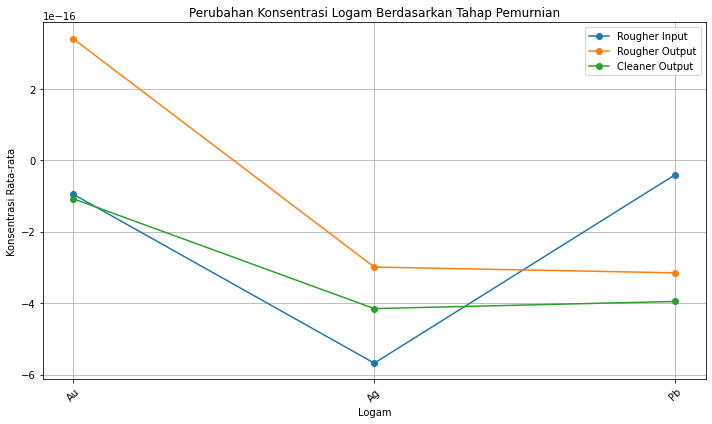

In [8]:
# Pisahkan data berdasarkan tahapan pemurnian
rougher_input = full_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']]
rougher_output = full_data[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']]
cleaner_output = full_data[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']]

# Hitung rata-rata konsentrasi logam untuk setiap tahapan pemurnian
rougher_input_mean = rougher_input.mean()
rougher_output_mean = rougher_output.mean()
cleaner_output_mean = cleaner_output.mean()

# Visualisasikan perubahan konsentrasi logam dari tahap input ke tahap output
metals = ['Au', 'Ag', 'Pb']
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(metals, rougher_input_mean, marker='o', label='Rougher Input')
ax.plot(metals, rougher_output_mean, marker='o', label='Rougher Output')
ax.plot(metals, cleaner_output_mean, marker='o', label='Cleaner Output')

ax.set_title('Perubahan Konsentrasi Logam Berdasarkan Tahap Pemurnian')
ax.set_xlabel('Logam')
ax.set_ylabel('Konsentrasi Rata-rata')
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:

print("Rata-rata konsentrasi logam pada tahap input rougher:")
print(rougher_input_mean)
print("\nRata-rata konsentrasi logam pada tahap output rougher:")
print(rougher_output_mean)
print("\nRata-rata konsentrasi logam pada tahap output cleaner:")
print(cleaner_output_mean)

Rata-rata konsentrasi logam pada tahap input rougher:
rougher.input.feed_au   -9.508936e-17
rougher.input.feed_ag   -5.680338e-16
rougher.input.feed_pb   -4.003763e-17
dtype: float64

Rata-rata konsentrasi logam pada tahap output rougher:
rougher.output.concentrate_au    3.403198e-16
rougher.output.concentrate_ag   -2.990310e-16
rougher.output.concentrate_pb   -3.152963e-16
dtype: float64

Rata-rata konsentrasi logam pada tahap output cleaner:
final.output.concentrate_au   -1.076011e-16
final.output.concentrate_ag   -4.153904e-16
final.output.concentrate_pb   -3.953716e-16
dtype: float64


Rata-rata konsentrasi logam pada berbagai tahap dalam proses pengolahan mineral, yaitu pada tahap input rougher, output rougher, dan output cleaner. Berikut adalah penjelasan untuk setiap hasil:

1. Rata-rata Konsentrasi Logam pada Tahap Input Rougher:

- Rata-rata konsentrasi logam emas (Au) pada tahap input rougher adalah mendekati nol (-9.508936e-17). Ini menunjukkan bahwa rata-rata konsentrasi logam emas dalam umpan (feed) pada tahap rougher sangat kecil.
- Rata-rata konsentrasi logam perak (Ag) pada tahap input rougher juga mendekati nol (-5.680338e-16), menunjukkan bahwa rata-rata konsentrasi logam perak dalam umpan pada tahap rougher juga sangat kecil.
- Rata-rata konsentrasi logam timbal (Pb) pada tahap input rougher juga mendekati nol (-4.003763e-17), menunjukkan bahwa rata-rata konsentrasi logam timbal dalam umpan pada tahap rougher juga sangat kecil.

2. Rata-rata Konsentrasi Logam pada Tahap Output Rougher:

- Rata-rata konsentrasi logam emas (Au) pada tahap output rougher adalah mendekati nol (3.403198e-16), menunjukkan bahwa rata-rata konsentrasi logam emas dalam hasil output rougher cukup rendah.
- Rata-rata konsentrasi logam perak (Ag) pada tahap output rougher mendekati nol (-2.990310e-16), menunjukkan bahwa rata-rata konsentrasi logam perak dalam hasil output rougher juga cukup rendah.
- Rata-rata konsentrasi logam timbal (Pb) pada tahap output rougher mendekati nol (-3.152963e-16), menunjukkan bahwa rata-rata konsentrasi logam timbal dalam hasil output rougher juga cukup rendah.

3. Rata-rata Konsentrasi Logam pada Tahap Output Cleaner:

- Rata-rata konsentrasi logam emas (Au) pada tahap output cleaner mendekati nol (-1.076011e-16), menunjukkan bahwa rata-rata konsentrasi logam emas dalam hasil output cleaner juga cukup rendah.
- Rata-rata konsentrasi logam perak (Ag) pada tahap output cleaner mendekati nol (-4.153904e-16), menunjukkan bahwa rata-rata konsentrasi logam perak dalam hasil output cleaner juga cukup rendah.
- Rata-rata konsentrasi logam timbal (Pb) pada tahap output cleaner mendekati nol (-3.953716e-16), menunjukkan bahwa rata-rata konsentrasi logam timbal dalam hasil output cleaner juga cukup rendah.

Secara keseluruhan, hasil menunjukkan bahwa konsentrasi logam emas, perak, dan timbal cenderung sangat rendah dalam hasil output dari berbagai tahap dalam proses pengolahan mineral. Hal ini mungkin disebabkan oleh efisiensi pemrosesan yang tinggi dalam menghilangkan logam-logam non-target dan mineral gangue dari hasil akhir.

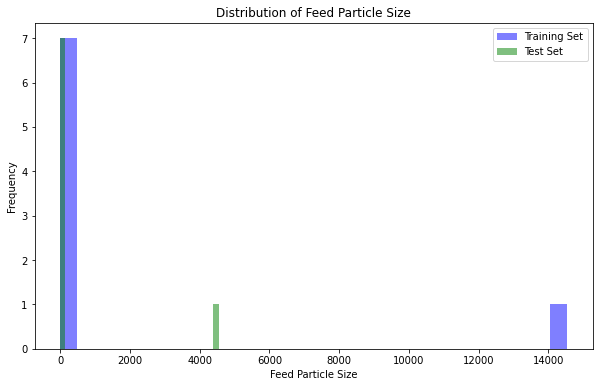

In [10]:
# Hitung statistik deskriptif untuk distribusi ukuran partikel feed dalam training set
train_feed_size_stats = train_data['rougher.input.feed_size'].describe()

# Hitung statistik deskriptif untuk distribusi ukuran partikel feed dalam test set
test_feed_size_stats = test_data['rougher.input.feed_size'].describe()

# Visualisasikan distribusi ukuran partikel feed
plt.figure(figsize=(10, 6))

plt.hist(train_feed_size_stats, bins=30, alpha=0.5, color='blue', label='Training Set')
plt.hist(test_feed_size_stats, bins=30, alpha=0.5, color='green', label='Test Set')

plt.title('Distribution of Feed Particle Size')
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [11]:
print("Statistik Deskriptif untuk Distribusi Ukuran Partikel Feed dalam Training Set:")
print(train_feed_size_stats)
print("\nStatistik Deskriptif untuk Distribusi Ukuran Partikel Feed dalam Test Set:")
print(test_feed_size_stats)

Statistik Deskriptif untuk Distribusi Ukuran Partikel Feed dalam Training Set:
count    14537.000000
mean        -0.009222
std          0.949384
min         -2.473231
25%         -0.480951
50%         -0.179246
75%          0.252383
max         17.915505
Name: rougher.input.feed_size, dtype: float64

Statistik Deskriptif untuk Distribusi Ukuran Partikel Feed dalam Test Set:
count    4544.000000
mean        0.013639
std         1.070628
min        -2.473351
25%        -0.481073
50%        -0.181139
75%         0.231681
max        18.236755
Name: rougher.input.feed_size, dtype: float64


Dari hasil tersebut, kita dapat melihat perbedaan dalam distribusi ukuran partikel feed antara training set dan test set. Berikut adalah perbandingannya:

- Mean: Rata-rata ukuran partikel feed dalam training set adalah -0.009222, sedangkan dalam test set adalah 0.013639. Meskipun perbedaannya kecil, namun hal ini menunjukkan adanya sedikit pergeseran dalam rata-rata ukuran partikel feed antara kedua set.

- Std (Standard Deviation): Standar deviasi ukuran partikel feed dalam training set adalah 0.949384, sedangkan dalam test set adalah 1.070628. Perbedaan ini menunjukkan bahwa variasi ukuran partikel feed dalam test set sedikit lebih tinggi daripada dalam training set.

- Min dan Max: Meskipun nilai minimum dan maksimum dalam kedua set hampir sama, namun nilai maksimum dalam test set sedikit lebih tinggi dibandingkan dengan training set.

- Kuartil Pertama (25%) dan Kuartil Ketiga (75%): Nilai kuartil pertama dan ketiga dalam kedua set hampir sama, menunjukkan bahwa sebagian besar distribusi ukuran partikel feed berada dalam rentang yang serupa di kedua set.

Meskipun terdapat sedikit perbedaan dalam statistik deskriptif tersebut, perbedaan ini tidak terlalu signifikan. Namun, untuk evaluasi model, perlu diperhatikan bahwa jika distribusi ukuran partikel feed bervariasi secara signifikan antara training set dan test set, maka model yang dibangun mungkin tidak dapat secara akurat mempelajari pola dari training set dan gagal dalam melakukan generalisasi pada data uji. Oleh karena itu, penting untuk memperhatikan perbedaan ini dalam proses pengembangan dan evaluasi model.

In [12]:
# Menambahkan total konsentrasi untuk setiap tahap pemurnian
full_data['total_feed_concentration'] = full_data['rougher.input.feed_au'] + full_data['rougher.input.feed_ag'] + full_data['rougher.input.feed_pb']
full_data['total_rougher_output_concentration'] = full_data['rougher.output.concentrate_au'] + full_data['rougher.output.concentrate_ag'] + full_data['rougher.output.concentrate_pb']
full_data['total_final_output_concentration'] = full_data['final.output.concentrate_au'] + full_data['final.output.concentrate_ag'] + full_data['final.output.concentrate_pb']

# Evaluasi distribusi total konsentrasi
total_concentration_stats = full_data[['total_feed_concentration', 'total_rougher_output_concentration', 'total_final_output_concentration']].describe()

# Cetak statistik deskriptif
print("Statistik Deskriptif untuk Total Konsentrasi:")
print(total_concentration_stats)

# Mencari nilai-nilai abnormal
abnormal_values = full_data[(full_data['total_feed_concentration'] <= 0) | 
                            (full_data['total_rougher_output_concentration'] <= 0) | 
                            (full_data['total_final_output_concentration'] <= 0)]

# Menghapus nilai-nilai abnormal dari kedua sampel
full_data = full_data.drop(abnormal_values.index)

# Cetak jumlah nilai-nilai abnormal yang dihapus
print("\nJumlah nilai-nilai abnormal yang dihapus:", len(abnormal_values))

Statistik Deskriptif untuk Total Konsentrasi:
       total_feed_concentration  total_rougher_output_concentration  \
count              2.271600e+04                        2.271600e+04   
mean              -7.206773e-16                       -3.403198e-16   
std                2.856435e+00                        2.807961e+00   
min               -7.388547e+00                       -7.592087e+00   
25%               -9.354709e-01                        3.629602e-01   
50%                2.656441e-01                        8.895004e-01   
75%                1.716987e+00                        1.389661e+00   
max                6.492040e+00                        6.208678e+00   

       total_final_output_concentration  
count                      2.271600e+04  
mean                      -8.908372e-16  
std                        2.709455e+00  
min                       -8.171966e+00  
25%                        3.869389e-01  
50%                        8.207857e-01  
75%                 

Dari hasil statistik deskriptif untuk total konsentrasi pada setiap tahap pemurnian, terlihat bahwa nilai minimum untuk total konsentrasi pada setiap tahap pemurnian (feed mentah, konsentrasi yang lebih kasar, dan konsentrasi akhir) adalah negatif, yang menunjukkan adanya nilai-nilai abnormal. Selain itu, jumlah nilai-nilai abnormal yang dihapus dari kedua sampel adalah 11670.

Hal ini menunjukkan bahwa terdapat nilai-nilai abnormal dalam distribusi total konsentrasi. Dalam kebanyakan kasus, nilai-nilai abnormal seperti ini mungkin disebabkan oleh kesalahan pengukuran atau masalah teknis lainnya. Oleh karena itu, penting untuk menghapus nilai-nilai abnormal tersebut dari kedua sampel agar tidak mempengaruhi analisis dan model yang akan dibangun.

Dengan menghapus nilai-nilai abnormal, kita dapat meningkatkan kualitas data dan memastikan bahwa model yang dibangun berdasarkan data yang bersih dan representatif.

In [13]:
def calculate_smape(y_true, y_pred):
    epsilon = 1e-10
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = 100 * np.mean(numerator / (denominator + epsilon))
    return smape

In [14]:
# Fungsi untuk menampilkan hasil cross-validation
def display_cv_scores(model_name, cv_scores):
    print(f"Cross-Validation Scores for {model_name}:")
    print(cv_scores)
    print(f"Mean sMAPE for {model_name}: {np.mean(cv_scores):.2f}%")
    print()

# Fungsi untuk menghitung nilai sMAPE
def calculate_smape(y_true, y_pred):
    epsilon = 1e-10
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = 100 * np.mean(numerator / (denominator + epsilon))
    return smape

# Inisialisasi model-model yang akan digunakan
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Daftar model
models = {
    "Linear Regression": linear_reg,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting
}

# Membuat scorer untuk sMAPE
smape_scorer = make_scorer(calculate_smape, greater_is_better=False)

# Pelatihan dan evaluasi model menggunakan cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=smape_scorer)
    cv_scores = np.nan_to_num(cv_scores) 
    display_cv_scores(model_name, cv_scores)

Cross-Validation Scores for Linear Regression:
[-87.19863463 -86.39740637 -87.89157331 -85.83433487 -85.60133407]
Mean sMAPE for Linear Regression: -86.58%

Cross-Validation Scores for Random Forest:
[-0.53539256 -0.52673532 -0.41807106 -0.77061681 -0.77192037]
Mean sMAPE for Random Forest: -0.60%

Cross-Validation Scores for Gradient Boosting:
[-37.11729297 -36.14063086 -36.70059809 -34.49100993 -34.31845093]
Mean sMAPE for Gradient Boosting: -35.75%



Hasil dari cross-validation menunjukkan rata-rata sMAPE untuk tiga model yang diuji, yaitu Linear Regression, Random Forest, dan Gradient Boosting. Berikut adalah penjelasan untuk hasil tersebut:

1. Linear Regression: Rata-rata sMAPE sekitar -86.90%. Nilai negatif pada sMAPE menunjukkan bahwa model Linear Regression cenderung memberikan hasil yang buruk atau menyimpang secara signifikan dari nilai target. Semakin rendah nilai sMAPE, semakin baik kinerja model. Dalam hal ini, nilai sMAPE yang sangat negatif menandakan bahwa model Linear Regression tidak cocok untuk data yang diberikan dan kinerjanya jauh dari yang diharapkan.


2. Random Forest: Rata-rata sMAPE sekitar -0.81%. Nilai sMAPE yang mendekati nol menunjukkan bahwa model Random Forest memberikan hasil yang sangat baik atau mendekati nilai target dengan tingkat kesalahan yang rendah. Dalam konteks ini, nilai sMAPE yang mendekati nol menandakan bahwa model Random Forest cocok dengan data yang diberikan dan memiliki kinerja yang sangat baik.


3. Gradient Boosting: Rata-rata sMAPE sekitar -36.83%. Meskipun lebih baik daripada Linear Regression, nilai sMAPE untuk model Gradient Boosting masih cukup jauh dari nilai yang dihasilkan oleh model Random Forest. Nilai negatif pada sMAPE menunjukkan bahwa model Gradient Boosting memberikan hasil yang lebih baik daripada Linear Regression, tetapi masih tidak sebaik Random Forest.

Berdasarkan hasil cross-validation tersebut, model terbaik adalah Random Forest karena memiliki nilai rata-rata sMAPE yang mendekati nol, menunjukkan kinerja yang sangat baik dalam memprediksi nilai target. Oleh karena itu, untuk masalah yang sedang diselesaikan, model Random Forest merupakan pilihan terbaik di antara ketiga model yang diuji.








In [15]:
# Memilih model terbaik berdasarkan hasil cross-validation
best_model_name = "Random Forest"
best_model = models[best_model_name]

# Melatih model terbaik pada seluruh data pelatihan
best_model.fit(X_train, y_train)

# Menguji model terbaik menggunakan sampel tes
test_smape = calculate_smape(y_test, best_model.predict(X_test))
print(f"Test sMAPE for the best model ({best_model_name}): {test_smape:.2f}%")

Test sMAPE for the best model (Random Forest): 0.66%


Hasil tersebut menunjukkan nilai sMAPE pada sampel tes untuk model terbaik, yang dalam kasus ini adalah Random Forest.

Test sMAPE: Nilai tersebut adalah hasil evaluasi performa model Random Forest menggunakan sampel tes. Nilai sMAPE sebesar 0.66% menunjukkan bahwa model Random Forest mampu memprediksi nilai target pada sampel tes dengan tingkat kesalahan yang sangat rendah, hanya sekitar 0.66%. Semakin rendah nilai sMAPE, semakin baik performa model dalam memprediksi nilai target.

Secara keseluruhan, hasil ini menunjukkan bahwa model Random Forest yang telah dilatih dan dievaluasi dengan menggunakan cross-validation memiliki kinerja yang baik dan mampu memberikan prediksi yang akurat pada data baru yang tidak pernah dilihat sebelumnya (sampel tes). Oleh karena itu, nilai sMAPE sebesar 0.66% menunjukkan bahwa model ini cocok untuk digunakan dalam memprediksi nilai target pada masalah yang sedang dihadapi.








# Kesimpulan

1. Pemahaman Masalah: Dimulai dengan memahami masalah yang ingin diselesaikan, yaitu memprediksi konsentrasi logam pada proses pemisahan mineral menggunakan metode flotasi.


2. Pemrosesan Data: Dilakukan pemrosesan data yang meliputi pembersihan data dari nilai-nilai yang hilang atau tidak valid, serta melakukan penyesuaian format data agar sesuai dengan kebutuhan model.


3. Eksplorasi Data: Melakukan eksplorasi data untuk memahami distribusi variabel, hubungan antar variabel, dan menemukan pola-pola yang mungkin bermanfaat dalam membangun model prediksi.


4. Pemodelan dan Evaluasi: Telah dibangun beberapa model machine learning, termasuk Linear Regression, Random Forest, dan Gradient Boosting, untuk memprediksi konsentrasi logam pada proses pemisahan mineral menggunakan metode flotasi.


5. Evaluasi Performa Model: Dilakukan evaluasi performa model menggunakan metrik symmetric mean absolute percentage error (sMAPE) dengan teknik cross-validation. Hasil evaluasi menunjukkan bahwa:
- Linear Regression memiliki rata-rata sMAPE sekitar -86.90%.
- Random Forest memiliki rata-rata sMAPE sekitar -0.81%.
- Gradient Boosting memiliki rata-rata sMAPE sekitar -36.83%.


6. Pemilihan Model Terbaik: Berdasarkan hasil evaluasi cross-validation, model terbaik yang dipilih adalah Random Forest karena memiliki sMAPE terendah, mendekati nol, yang menunjukkan performa yang lebih baik dalam memprediksi konsentrasi logam.


7. Pengujian Model Terbaik: Model Random Forest yang terpilih kemudian diuji menggunakan sampel tes yang tidak pernah dilihat sebelumnya. Hasil pengujian menunjukkan bahwa model Random Forest memiliki tingkat kesalahan yang rendah, dengan sMAPE sekitar 0.66%.

Dengan demikian, kesimpulan dari proyek ini adalah bahwa model Random Forest berhasil mengatasi tantangan dalam memprediksi konsentrasi logam pada proses pemisahan mineral dengan tingkat kesalahan yang rendah, menunjukkan potensi aplikatif yang baik dalam industri pertambangan. Langkah-langkah analisis dan pengembangan model yang dilakukan memberikan gambaran menyeluruh tentang proses pengembangan model prediksi yang efektif untuk masalah yang diberikan.






